# 1. Fitter
### Находит параметры и решение, наиболее подогнанное к данным по метрике MSE

In [1]:
import math
import numpy as np, matplotlib.pyplot as plt
from scipy.integrate import odeint
import sys

try:
    from tqdm.notebook import tqdm
except Exception:
    print('For a nice progress bar install tqdm (pip3 install tqdm)', file=sys.stderr)
    def tqdm(iterable, *args, **kwargs):
        return iterable

    
def progress_wrapper(iterable, level, max_progress_level):
    if level == 0:
        return tqdm(iterable)
    elif level <= max_progress_level:  # configurable
        return tqdm(iterable, leave=False)
    else:
        return iterable
    

def compute_loss(time_points, predicted_metrics, true_metrics):
    loss_sum = 0.0
    # Iterace through infected, recovered and dead
    for predicted, true in zip(predicted_metrics, true_metrics):
        assert predicted.shape[0] == true.shape[0], "expected solution's size to be {}, but got {}".format(true.shape[0], predicted.shape[0])
        loss_sum += np.mean((true - predicted) ** 2)
    return loss_sum


def cut_metrics(metrics, from_idx, to_idx):
    if to_idx is None:
        return [x[from_idx:] for x in metrics]
    else:
        return [x[from_idx:to_idx] for x in metrics]


def fit(ode_system_getter, time_points, params, to_metrics, true_metrics, max_progress_level=1, val_samples=0):
    """
    ode_system_getter: функция, которая получает набор параметров из params и возвращает tuple,
                       в котором первый элемент – функция, задающая систему уравнений
                       (и принимающая только параметры y и t)
                       и соответствующая аргументу func функции scipy.integrate.odeint,
                       а второй элемент – вектор начальных условий y0 функции scipy.integrate.odeint
    time_points: точки, для которых нужно решить систему уранений. Аналогично параметру t в scipy.integrate.odeint
    params: список, в котором каждый i-тый элемент –
            список возможных значений i-того параметра, передаваемого в ode_system_getter
    to_metrics: функция, принимающая solution (результат функции scipy.integrate.odeint)
                и отдающая список метрик, по которым будет производиться оценка параметров.
                каждая метрика – одномерный numpy-массив значений
    true_metrics: список метрик для данных, под которые мы подстраиваемся
                  каждая метрика – одномерный numpy-массив значений
    max_progress_level: глубина вложенных циклов, для которых будет отображаться progress-bar. Считается от 0.
    val_samples: количество элементов, отсекаемых на валидацию.
                 целое число означает количество элементов,
                 дробное в интервале (0;1) – долю от общего числа элементов
                  
    
    """
    
    val_len = math.ceil(len(time_points)*val_samples) if val_samples < 1 else val_samples
    train_len = len(time_points) - val_len
    assert train_len > 0, 'Too big value for val_samples, no train samples left'
    if val_len <= 0:
        print('Too small value for val_samples, no validation loss will be computed', file=sys.stderr)
    train_points = time_points[:train_len]
    val_points = time_points[train_len:]
    true_train = cut_metrics(true_metrics, 0, train_len)
    true_val = cut_metrics(true_metrics, train_len, None)
    
    def fit_stage(left_params, current_values, level):
        if left_params:
            best_train_loss = None
            best_val_loss = None
            best_solution = None
            best_params = None
            for param_value in progress_wrapper(left_params[-1], level, max_progress_level):
                new_values = current_values + (param_value,)
                return_value = fit_stage(left_params[:-1], new_values, level+1)
                if return_value is None:
                    continue
                train_loss, val_loss, solution, params_for_loss = return_value
                if best_train_loss is None or best_train_loss > train_loss:
                    best_train_loss = train_loss
                    best_val_loss = val_loss
                    best_solution = solution
                    best_params = params_for_loss
            return best_train_loss, best_val_loss, best_solution, best_params
        else:
            return_value = ode_system_getter(*list(reversed(current_values)))
            if return_value is None:  # e.g. invalid parameters
                return None
            ode_system, initial_conditions = return_value
            solution = odeint(ode_system, initial_conditions, time_points)
            train_loss = compute_loss(train_points, cut_metrics(to_metrics(solution), 0, train_len), true_train)
            if val_len > 0:
                val_loss = compute_loss(val_points, cut_metrics(to_metrics(solution), train_len, None), true_val)
            else:
                val_loss = 0.0
            return train_loss, val_loss, solution, current_values
    
    best_train_loss, val_loss, best_solution, best_params = fit_stage(params, tuple(), 0)
    return best_train_loss, val_loss, best_solution, tuple(reversed(best_params))

# modified SEIR

In [2]:
import pandas as pd

ITALY_POPULATION = 60461826
N=ITALY_POPULATION

params = [
    [8, 10, 15, 20],
    [2, 5, 7],
    [20, 24, 28],
    [0.575, 0.525, 0.475, 0.625],
    [0.05, 0.125, 0.175],
    [0.025, 0.06],
    [10, 14, 18],
    [18, 22, 27],
    [5, 7],
]

def func_getter(
    IncubPeriod,
    InfectPhaseIncubPeriod,
    DurMildInf,
    FracMild,
    FracSevere,
    CFR,
    TimeICUDeath,
    DurHosp,
    DurAsympt,
):
    # Если набор параметров невалиден, можно просто вернуть None, тогда такой набор будет пропущен
    if FracMild + FracSevere > 1:
        return None
    FracCritical = 1 - FracMild - FracSevere
    
    b=np.zeros(5)
    g=np.zeros(5)
    p=np.zeros(3)

    a1=1/InfectPhaseIncubPeriod
    a0=1/(IncubPeriod-InfectPhaseIncubPeriod)
    u=(1/TimeICUDeath)*(CFR/FracCritical)
    g[4]=(1/TimeICUDeath)-u
    p[2]=(1/DurHosp)*(FracCritical/(FracCritical+FracSevere))
    g[3]=(1/DurHosp)-p[2]
    g[2]=(1/DurMildInf)*FracMild
    g[1]=(1/DurAsympt) 
    p[1]=(1/DurMildInf)-g[1]
    b=np.array([0,1,0,0,0])
    
    initial_conditions = np.zeros(8)
    initial_conditions[0] = 1
    
    def ode_system(y,t): 
        dy=[0,0,0,0,0,0,0,0]
        S=N-sum(y);
        dy[0] = (np.dot(b[1:4],y[1:4]))*S / N - a0*y[0] # E
        dy[1] = a0*y[0] - a1*y[1] # E1
        dy[2] = 0.7*a1*y[1] - g[1]*y[2] # I0
        dy[3] = 0.3*a1*y[1]-(g[2]+p[1])*y[3] #I1
        dy[4] = p[1]*y[3] -(g[3]+p[2])*y[4] #I2
        dy[5] = p[2]*y[4] -(g[4]+u)*y[5] #I3
        dy[6] = np.dot(g[1:],y[2:6]) #R
        dy[7] = u*y[5] #D

        return dy
    
    return ode_system, initial_conditions

# Наши метрики: infected, recovered, dead
def solution_to_IRD(solution):
    # В нашем случае solution=[susceptible, mild, severe, icu, recovered, dead]
    recovered = (solution[:, 2] + solution[:, 3] + solution[:, 4] + solution[:, 5])  # i0+i1+i2+i3, without E
    infected = solution[:, 6] * 80
    dead = solution[:, 7]
    return infected, recovered, dead

data = pd.read_csv('../spain.csv')
data = data[10:]

infected = data['Заражений'] - (data['Выздоровлений'] + data['Смертей'])

recovered = data['Выздоровлений']
dead = data['Смертей']

true_ird = (infected, recovered)
time_points = np.arange(true_ird[0].shape[0]) 

In [3]:
train_loss, val_loss, best_solution, best_params = fit(
    func_getter,
    time_points,
    params,
    solution_to_IRD,
    true_ird,
    val_samples=0.25,
)
print(round(train_loss, 4), round(val_loss, 4), best_params)


2754449992.7848 3733159088336087.5 (20, 5, 28, 0.475, 0.175, 0.025, 10, 18, 5)


In [6]:
# Небольшая функция для быстрой отрисовки графичков, объединяющая реальные данные и смоделированные
def plot_data_together(time_points, predicted_data, true_data, upper_limit, labels=None):
    colors = ['b', 'g', 'r', 'y', 'k', 'm']
    if not labels:
        labels = ['']*len(true_data)
    susceptible, infected = true_data
    plt.figure(figsize=(13,5))
    plt.subplot(1,2,1)
    cnt = 0
    for y_pred, y_true, color, label in zip(predicted_data, true_data, colors, labels):
        cnt += 1
        if cnt < 3:
            plt.plot(time_points, y_true, color+'--', label=label+' (true)', alpha=0.7)
            plt.plot(time_points, y_pred, color, label=label+' (pred)')
            
        
    plt.xlabel("Time (days)")
    plt.ylabel("Number of people")
    plt.legend()
    plt.ylim([0, upper_limit])

    #Same plot but on log scale
    plt.subplot(1,2,2)
    cnt = 0
    for y_pred, y_true, color, label in zip(predicted_data, true_data, colors, labels):
        cnt += 1
        if cnt < 3:
            plt.plot(time_points, y_true, color+'--', label=label+' (true)', alpha=0.7)
            plt.plot(time_points, y_pred, color, label=label+' (pred)')
    plt.semilogy()
    plt.xlabel("Time (days)")
    plt.ylabel("Number of people")
    plt.legend()
    plt.ylim([0.001, upper_limit])

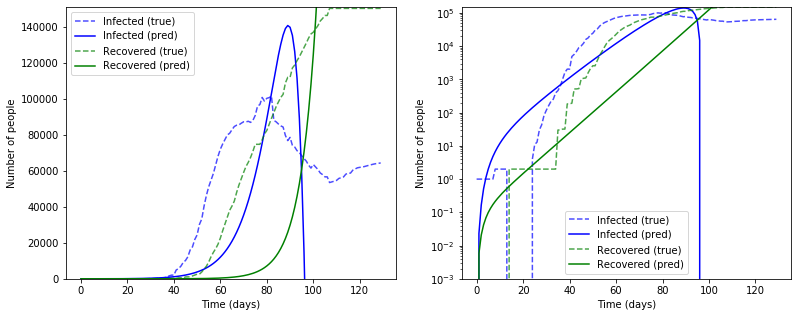

In [7]:
plot_data_together(time_points, solution_to_IRD(best_solution), true_ird, N/400, labels=["Infected", "Recovered", "Dead"])